# Unsupervised learning & clustering

In [277]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from iso3166 import countries as ctr
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import preprocessing
import seaborn as sns

### 1. Reading data
The woldbank_development_2015.csv (can be found in the same folder with this notebook) file contains the World Development Indicators for the 2015 year, downloaded from [The World Bank's webpage](https://databank.worldbank.org/source/world-development-indicators#).


 - Look at the data in any text editor. Build up an overall sense how the data is built up and how is the missing values are represented.
 - Read the file into a pandas dataframe and tell pandas which special pattern means if a value is missing. 
 - The data is in a long format. Convert it into a wide format, where each row is a single country and the columns are the measured features, the Series Codes (eg the first column is 'EG.CFT.ACCS.ZS', the second is 'EG.ELC.ACCS.ZS'. Order of the columns does not matter)!
 - Keep only those rows, which represents counties and NOT regions. Luckily they are well separated in the order they occur!
 - Convert the features to numeric format, which will be needed for modeling!

In [2]:
#getting the data from the .csv file 
data = pd.read_csv('woldbank_development_2015.csv')

#replacing the NaN values with the number -999
data = data.fillna(-999)

#showing the data
data

,Country Name,Country Code,Series Name,Series Code,2015 [YR2015]
0,Afghanistan,AFG,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,30.1
1,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,71.5
2,Afghanistan,AFG,"Access to electricity, rural (% of rural popul...",EG.ELC.ACCS.RU.ZS,64.573353938483
3,Afghanistan,AFG,"Access to electricity, urban (% of urban popul...",EG.ELC.ACCS.UR.ZS,92.5
4,Afghanistan,AFG,Account ownership at a financial institution o...,FX.OWN.TOTL.ZS,..
...,...,...,...,...,...
379368,-999,-999,-999,-999,-999
379369,-999,-999,-999,-999,-999
379370,-999,-999,-999,-999,-999
379371,Data from database: World Development Indicators,-999,-999,-999,-999


In [3]:
#getting the different codes and countries in a list

different_codes = []
for i in range(0,len(data)-2):
    code = data['Series Code'][i]
    if code not in different_codes:
        different_codes.append(code)

In [4]:
#getting the different countries in a list

different_country_names = []
for i in range(0,len(data)-2):
    country_name = data['Country Name'][i]
    if country_name not in different_country_names:
        different_country_names.append(country_name)

In [5]:
#getting the different country codes in a list

different_countries = []
for i in range(0,len(data)-2):
    country = data['Country Code'][i]
    if country not in different_countries:
        different_countries.append(country)

In [6]:
#creating the value of the dictionary keys

values = np.zeros(len(different_codes))-999

In [7]:
#filling the dictionaries with -999 values and replacing the existing columns from the dataset

list_of_dictionaries = []

j = 0
current_country = different_countries[j]
dictionary = dict(zip(different_codes, values))

for i in range(0,len(data)):
    if data['Country Code'][i] == current_country:
        name_of_value = str(data['Series Code'][i])
        value = str(data['2015 [YR2015]'][i])
        dictionary.update({name_of_value: value})
        
    else:
        list_of_dictionaries.append(dictionary)
        j += 1
        current_country = different_countries[j]
        dictionary = dict(zip(different_codes, values))
        name_of_value = str(data['Series Code'][i])
        value = str(data['2015 [YR2015]'][i])
        dictionary.update({name_of_value: value})        

In [8]:
#we have to remove the last element from the list, because it's not an actual value

different_countries.remove(-999)

In [9]:
#creating the new dataframe and renaming the rows by the country names

df = pd.DataFrame.from_dict(list_of_dictionaries)

for i in range(0,len(df)):
    df = df.rename(index={df.index[i]: str(different_country_names[i])})
    
#dropping the last column, since it only contains -999 values

df = df.drop(df.columns[-1], axis=1)   

#replacing the '..' values with Nan

df = df.replace(to_replace = '..', value = np.nan)

#adding the country code to the dataframe

df['Country Code'] = different_countries

#shifting the country code to the first column

cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]

df.head(5)

,Country Code,EG.CFT.ACCS.ZS,EG.ELC.ACCS.ZS,EG.ELC.ACCS.RU.ZS,EG.ELC.ACCS.UR.ZS,FX.OWN.TOTL.ZS,FX.OWN.TOTL.FE.ZS,FX.OWN.TOTL.MA.ZS,FX.OWN.TOTL.OL.ZS,FX.OWN.TOTL.40.ZS,...,SG.DMK.ALLD.FN.ZS,SG.VAW.REAS.ZS,SG.VAW.ARGU.ZS,SG.VAW.BURN.ZS,SG.VAW.GOES.ZS,SG.VAW.NEGL.ZS,SG.VAW.REFU.ZS,SP.M15.2024.FE.ZS,SP.M18.2024.FE.ZS,SH.DYN.AIDS.FE.ZS
Afghanistan,AFG,30.1,71.5,64.573353938483,92.5,NaN,NaN,NaN,NaN,NaN,...,32.6,80.2,59.2,18.2,66.9,48.4,33.4,8.8,34.8,28.6
Albania,ALB,75.37,100,100,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.5
Algeria,DZA,92.7,99.9313659667969,99.7645649276127,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.3
American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,AND,100,100,100,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
#at first, I tried to remove the non country values by importing the iso1366 library 
#and compare those values to the dataframe labels
#the code for this is shown here:

list_of_all_countries = []

for c in ctr:
    list_of_all_countries.append(c[0])
    
    
#let's see if all our labeled countries are in this list or not
#if not, we will collect them and then drop them from the dataframe

list_of_indices_to_drop = []

for i in range(0,len(different_country_names)-1):
    if different_country_names[i] not in list_of_all_countries:
        list_of_indices_to_drop.append(i)

        
#droping the from the dataframe

df_dropped_countries_first = df.drop(df.index[list_of_indices_to_drop])

df_dropped_countries_first.head(5)

,Country Code,EG.CFT.ACCS.ZS,EG.ELC.ACCS.ZS,EG.ELC.ACCS.RU.ZS,EG.ELC.ACCS.UR.ZS,FX.OWN.TOTL.ZS,FX.OWN.TOTL.FE.ZS,FX.OWN.TOTL.MA.ZS,FX.OWN.TOTL.OL.ZS,FX.OWN.TOTL.40.ZS,...,SG.DMK.ALLD.FN.ZS,SG.VAW.REAS.ZS,SG.VAW.ARGU.ZS,SG.VAW.BURN.ZS,SG.VAW.GOES.ZS,SG.VAW.NEGL.ZS,SG.VAW.REFU.ZS,SP.M15.2024.FE.ZS,SP.M18.2024.FE.ZS,SH.DYN.AIDS.FE.ZS
Afghanistan,AFG,30.1,71.5,64.573353938483,92.5,NaN,NaN,NaN,NaN,NaN,...,32.6,80.2,59.2,18.2,66.9,48.4,33.4,8.8,34.8,28.6
Albania,ALB,75.37,100,100,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.5
Algeria,DZA,92.7,99.9313659667969,99.7645649276127,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.3
American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,AND,100,100,100,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#after some thinking, I realized that I could have just plotted all the values before Zimbabwe
#which is implied by the following hint: 'Luckily they are well separated in the order they occur!'

list_for_droping = np.linspace(different_country_names.index('Zimbabwe'), len(df)-1, len(df)-different_country_names.index('Zimbabwe'), dtype=int)

df_dropped_countries_second = df.drop(df.index[list_for_droping])

df_dropped_countries_second

,Country Code,EG.CFT.ACCS.ZS,EG.ELC.ACCS.ZS,EG.ELC.ACCS.RU.ZS,EG.ELC.ACCS.UR.ZS,FX.OWN.TOTL.ZS,FX.OWN.TOTL.FE.ZS,FX.OWN.TOTL.MA.ZS,FX.OWN.TOTL.OL.ZS,FX.OWN.TOTL.40.ZS,...,SG.DMK.ALLD.FN.ZS,SG.VAW.REAS.ZS,SG.VAW.ARGU.ZS,SG.VAW.BURN.ZS,SG.VAW.GOES.ZS,SG.VAW.NEGL.ZS,SG.VAW.REFU.ZS,SP.M15.2024.FE.ZS,SP.M18.2024.FE.ZS,SH.DYN.AIDS.FE.ZS
Afghanistan,AFG,30.1,71.5,64.573353938483,92.5,NaN,NaN,NaN,NaN,NaN,...,32.6,80.2,59.2,18.2,66.9,48.4,33.4,8.8,34.8,28.6
Albania,ALB,75.37,100,100,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.5
Algeria,DZA,92.7,99.9313659667969,99.7645649276127,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.3
American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,AND,100,100,100,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,VNM,63.81,99.7993927001953,99.6969266198856,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.9
Virgin Islands (U.S.),VIR,NaN,100,100,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
West Bank and Gaza,PSE,NaN,99.9,99.600466985925,99.9978942871094,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Yemen, Rep.",YEM,64.28,71.1798858642578,57.4115089052768,97.0019760131836,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22


In [12]:
#Converting the features to numeric format:
#we need a dictionary for this:

if -999 in different_codes:
    different_codes.remove(-999)

values_for_dict = list(range(0, len(different_codes))) 
dictionary2 = {different_codes[i]: values_for_dict[i] for i in range(len(different_codes))} 

df_dropped_countries_second = df_dropped_countries_second.rename(columns=dictionary2)

df_dropped_countries_second.head(5)

,Country Code,0,1,2,3,4,5,6,7,8,...,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436
Afghanistan,AFG,30.1,71.5,64.573353938483,92.5,NaN,NaN,NaN,NaN,NaN,...,32.6,80.2,59.2,18.2,66.9,48.4,33.4,8.8,34.8,28.6
Albania,ALB,75.37,100,100,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.5
Algeria,DZA,92.7,99.9313659667969,99.7645649276127,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.3
American Samoa,ASM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Andorra,AND,100,100,100,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2. Data preprocessing and inspection

 - Visualize the missing values!
 - Keep only those countries which has less than 700 missing features in the original table and keep features which were missing in less than 20 country in the original table
 - Visualize the missing values again! Now really only a few entries are missing. Impute the missing values with its feature's mean value!
 - How many counties and features do we have left?
 - Read the kept features' descriptions. In the original table the Series Name describe the meaning of the features. What do you think, based only on these information, which counties are the most similar to Hungary? And Norway?  

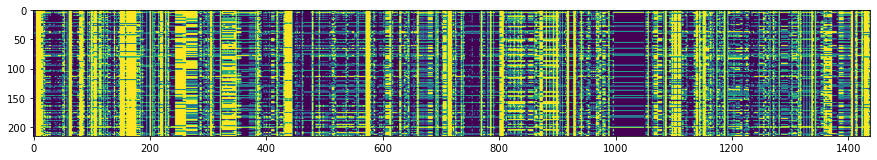

In [13]:
#visualizing the missing values

plt.figure(figsize=(15,10))
plt.imshow(df_dropped_countries_second.isna())
plt.show()

In [14]:
#counting the nan values in the rows

list_of_indices_to_remove = []

for i in range(0,len(df_dropped_countries_second)):
    number_of_nans = df_dropped_countries_second.iloc[i].isna().sum()
    if number_of_nans > 699:
        list_of_indices_to_remove.append(i)

df_dropped_countries_third = df_dropped_countries_second.drop(df_dropped_countries_second.index[list_of_indices_to_remove])

df_dropped_countries_third.head()

,Country Code,0,1,2,3,4,5,6,7,8,...,1427,1428,1429,1430,1431,1432,1433,1434,1435,1436
Afghanistan,AFG,30.1,71.5,64.573353938483,92.5,NaN,NaN,NaN,NaN,NaN,...,32.6,80.2,59.2,18.2,66.9,48.4,33.4,8.8,34.8,28.6
Albania,ALB,75.37,100,100,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.5
Algeria,DZA,92.7,99.9313659667969,99.7645649276127,100,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.3
Angola,AGO,47.36,42,3.8150702987396,64,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.6
Argentina,ARG,98.29,99.8271179199219,98.1367605031083,99.9840850830078,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32


In [15]:
#counting the nan values in the columns and removing them

list_of_indices_to_remove = []

for i in range(0,1437):
    value =  df_dropped_countries_second[i].isna().sum()
    if value > 19:
        list_of_indices_to_remove.append(i)

df_dropped_countries_fourth = df_dropped_countries_third
        
for i in list_of_indices_to_remove:
    df_dropped_countries_fourth = df_dropped_countries_fourth.drop(columns=[i])       
    
df_dropped_countries_fourth

,Country Code,1,2,3,31,34,37,40,58,59,...,1219,1231,1232,1279,1341,1344,1380,1408,1409,1410
Afghanistan,AFG,71.5,64.573353938483,92.5,273963247.118766,2.5944472967714,9147826.09775918,810771.842175775,58.0675795729559,379100,...,6,74,2.15031247963196,652860,2150,0.482763041510179,55,8535606,24.803,3.95176219129098
Albania,ALB,100,100,100,139983655.893882,3.12424105456822,105112816.576057,17351913.7345082,42.8576660156252,11743.0004882813,...,7,197,68.3860849244091,28750,9472.5,1.82139199623227,87,1654503,57.434,1.48476433256912
Algeria,DZA,99.9313659667969,99.7645649276127,100,4643143344.02584,4.4671956,16616045030.0048,9338828.93239816,17.4059294622839,414563.984375,...,7,152,3.82601450739119,2381740,97278.99,16.3116061029434,80,28146511,70.848,2.93432016018453
Angola,AGO,42,3.8150702987396,64,1048598775.80239,3.57,9281751343.19969,0,47.4773401780701,591900,...,6,227,8.14075808245483,1246700,496104,10.772403752276,58,17691524,63.446,4.57219158120625
Argentina,ARG,99.8271179199219,98.1367605031083,99.9840850830078,6099573771.78912,5.26092698635602,4799964806.20974,1267250889.66812,54.3357121193851,1487000,...,6,5317,123.272841307535,2780400,817962.7,1.3562564931771,87,39467043,91.503,1.21579706300955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uzbekistan,UZB,100,100,100,3120890577.66909,9.3747642,2594354131.35321,2188977472.14185,62.9290079924777,267700,...,8,177,5.65515081999687,447400,59852.4,8.67307403112319,67,15884192,50.75,1.54741236865574
Vanuatu,VUT,52.3857498168945,40.0490006002108,89.4729232788086,4002709.77933262,4.77800839749845,0,0,15.3404429860541,1870,...,7,34,125.401099103751,12190,82201.54,0.810132551867862,80,67677,24.961,3.10944755167171
Vietnam,VNM,99.7993927001953,99.6969266198856,100,5710310245.74902,4.61226764838769,2195891598.35636,238584113.449581,39.2556519495598,121720,...,7,3033,32.7265396245345,331230,6207514,4.44321996726026,55,31333193,33.809,3.11803264367973
West Bank and Gaza,PSE,99.9,99.600466985925,99.9978942871094,91172833.8625764,NaN,0,0,49.3222613667332,2969.20013427734,...,8,139,32.5519918540397,6020,3503,0,80,3218283,75.368,2.62940953806647


In [16]:
#removing the appropriate values from the dict values:

for i in list_of_indices_to_remove:
    if i in values_for_dict:
        values_for_dict.remove(i)
        
len(values_for_dict)

116

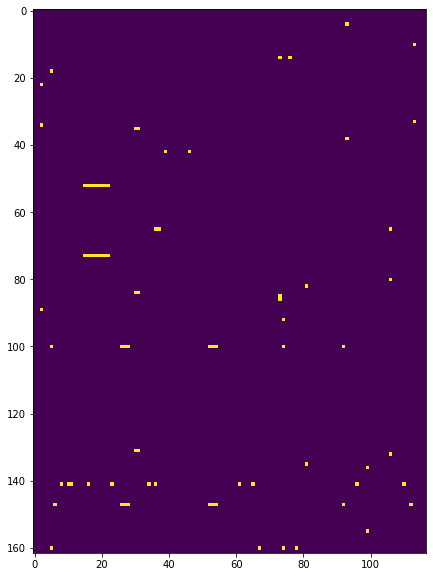

In [17]:
#visualizing the missing values

plt.figure(figsize=(15,10))
plt.imshow(df_dropped_countries_fourth.isna())
plt.show()

In [18]:
#let's check what the maximum number of NaN values is amongst the columns:

max_num_nan_column = []

for i in values_for_dict:
    max_num_nan_column.append(df_dropped_countries_fourth[i].isna().sum())
    
np.max(max_num_nan_column)

3

In [19]:
#let's check what the maximum number of NaN values is amongst the rows:

max_num_nan_row = []

for i in range(0,len(df_dropped_countries_fourth)):
    max_num_nan_row.append(df_dropped_countries_fourth.iloc[i].isna().sum())
    
np.max(max_num_nan_row)

11

In [20]:
#looks like we successfully removed the appropriate rows and columns!
#we have 162 rows (countries) and 117 columns (features) left

In [21]:
#in the next exercise, we need to get the average of the columns (features) and replace the nan values with the results

for j in values_for_dict:

    list_of_values_to_avg = []

    for i in list(df_dropped_countries_fourth[j]):
        list_of_values_to_avg.append(float(i))

    df_dropped_countries_fourth[j] = df_dropped_countries_fourth[j].replace([np.nan], str(np.nanmean(list_of_values_to_avg)))
    
df_dropped_countries_fourth

,Country Code,1,2,3,31,34,37,40,58,59,...,1219,1231,1232,1279,1341,1344,1380,1408,1409,1410
Afghanistan,AFG,71.5,64.573353938483,92.5,273963247.118766,2.5944472967714,9147826.09775918,810771.842175775,58.0675795729559,379100,...,6,74,2.15031247963196,652860,2150,0.482763041510179,55,8535606,24.803,3.95176219129098
Albania,ALB,100,100,100,139983655.893882,3.12424105456822,105112816.576057,17351913.7345082,42.8576660156252,11743.0004882813,...,7,197,68.3860849244091,28750,9472.5,1.82139199623227,87,1654503,57.434,1.48476433256912
Algeria,DZA,99.9313659667969,99.7645649276127,100,4643143344.02584,4.4671956,16616045030.0048,9338828.93239816,17.4059294622839,414563.984375,...,7,152,3.82601450739119,2381740,97278.99,16.3116061029434,80,28146511,70.848,2.93432016018453
Angola,AGO,42,3.8150702987396,64,1048598775.80239,3.57,9281751343.19969,0,47.4773401780701,591900,...,6,227,8.14075808245483,1246700,496104,10.772403752276,58,17691524,63.446,4.57219158120625
Argentina,ARG,99.8271179199219,98.1367605031083,99.9840850830078,6099573771.78912,5.26092698635602,4799964806.20974,1267250889.66812,54.3357121193851,1487000,...,6,5317,123.272841307535,2780400,817962.7,1.3562564931771,87,39467043,91.503,1.21579706300955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uzbekistan,UZB,100,100,100,3120890577.66909,9.3747642,2594354131.35321,2188977472.14185,62.9290079924777,267700,...,8,177,5.65515081999687,447400,59852.4,8.67307403112319,67,15884192,50.75,1.54741236865574
Vanuatu,VUT,52.3857498168945,40.0490006002108,89.4729232788086,4002709.77933262,4.77800839749845,0,0,15.3404429860541,1870,...,7,34,125.401099103751,12190,82201.54,0.810132551867862,80,67677,24.961,3.10944755167171
Vietnam,VNM,99.7993927001953,99.6969266198856,100,5710310245.74902,4.61226764838769,2195891598.35636,238584113.449581,39.2556519495598,121720,...,7,3033,32.7265396245345,331230,6207514,4.44321996726026,55,31333193,33.809,3.11803264367973
West Bank and Gaza,PSE,99.9,99.600466985925,99.9978942871094,91172833.8625764,4.194449636522738,0,0,49.3222613667332,2969.20013427734,...,8,139,32.5519918540397,6020,3503,0,80,3218283,75.368,2.62940953806647


In [203]:
#getting the country codes to a list:

country_code_list_filtered = df_dropped_countries_fourth['Country Code']

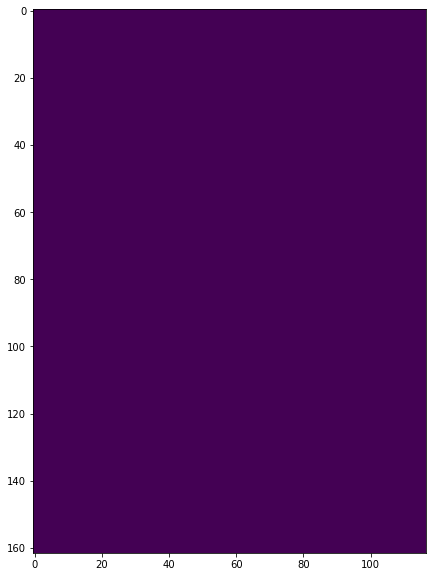

In [22]:
#checking, if we replaced all the necessary nan values with the averages

plt.figure(figsize=(15,10))
plt.imshow(df_dropped_countries_fourth.isna())
plt.show()

In [224]:
#searching for Hungary and Norway in the dataset:

hun_values = list(df_dropped_countries_fourth[df_dropped_countries_fourth['Country Code']=='HUN'].iloc[0])
hun_values.pop(0)
hun_values = list(map(float, hun_values))
hun_values = np.array(hun_values)
hun_index = 66

#Hungary's index: 66


norway_values = list(df_dropped_countries_fourth[df_dropped_countries_fourth['Country Code']=='NOR'].iloc[0])
norway_values.pop(0)
norway_values = list(map(float, norway_values))
norway_values = np.array(norway_values)
nor_index = 112

#Norway's index: 112


#what I'll do is the following: I collect all the values from the columns and calcualate the ration of the value from each
#country and Hungary. Then I add together all the percentages and get a value. 
#the closer the value is to 1, the closer it's properties match
#I'll do the same thing with Norway


In [24]:
#since I'm calculating the difference from the hungarian and norwegian values in percentage, I'll have a problem when a n value is 0
#I decided not to take those values in account, since they can not be expressed in percentages
#then the percentages are added together
#since these are percentage differences from the norwegian and hungarian values, we need the closest to 0
#I took care not to calculate the hungarian and norwegian values in (obviously those values would be 0)

deviation_from_hun_list = []
deviation_from_nor_list = []

for j in range(0,len(df_dropped_countries_fourth)):

    array_of_features = list(df_dropped_countries_fourth.iloc[j])
    array_of_features.pop(0)
    array_of_features = list(map(float, array_of_features))
    array_of_features = np.array(array_of_features)

    if j != 66:
        
        hun_percentage_difference_list = []
        
        for i in range(0,len(hun_values)):
            if hun_values[i] != 0.0:    
                percentage_difference = abs(100 - (array_of_features[i]/hun_values[i])*100)
                hun_percentage_difference_list.append(percentage_difference)
                
        deviation_from_hun = sum(hun_percentage_difference_list)/len(hun_percentage_difference_list)       
        deviation_from_hun_list.append(deviation_from_hun)

    if j != 112:
        
        nor_percentage_difference_list = []
        
        for i in range(0,len(norway_values)):
            if norway_values[i] != 0.0:    
                percentage_difference = abs(100 - (array_of_features[i]/norway_values[i])*100)
                nor_percentage_difference_list.append(percentage_difference)            

        deviation_from_norway = sum(nor_percentage_difference_list)/len(nor_percentage_difference_list)
        deviation_from_nor_list.append(deviation_from_norway)

        
#let's see the closest values to the hungarian and norwegian data:

closest_to_hun = np.min(deviation_from_hun_list)
closest_to_nor = np.min(deviation_from_nor_list)


#let's get the indices of these values:

index_of_closest_hun = deviation_from_hun_list.index(closest_to_hun)
index_of_closest_nor = deviation_from_nor_list.index(closest_to_nor)


#let's get these two values, so we see which ones are the closest:

In [25]:
#so the closest one to Hungary is:

df_dropped_countries_fourth.iloc[index_of_closest_hun:index_of_closest_hun+1]

,Country Code,1,2,3,31,34,37,40,58,59,...,1219,1231,1232,1279,1341,1344,1380,1408,1409,1410
Czech Republic,CZE,100,100,99.9799957275391,3027605202.53409,5.71889242576865,94422855.6786806,0,45.2532055433234,34940,...,8,21607,2048.8222188023,78870,24041,0.307669102347716,87,7748928,73.477,0.323237456440875


In [26]:
# and the closest one to Norway is:

df_dropped_countries_fourth.iloc[index_of_closest_nor:index_of_closest_nor+1]

,Country Code,1,2,3,31,34,37,40,58,59,...,1219,1231,1232,1279,1341,1344,1380,1408,1409,1410
Austria,AUT,100,100,100,1857590896.75861,5.20846930751717,189055570.783915,6434844.58264628,32.9417255251407,27184.4995117188,...,8,26636,3081.90763093797,83879.00390625,3853.4,0.134073998402322,87,4988134,57.715,1.44900148037757


### 3. PCA
 - Perform PCA with 3 principal components on the filtered, imputed data (from now on, data refers to the filtered, imputed dataset)
 - Plot the three embedded 2D combination next to each other (0 vs 1, 0 vs 2 and 1 vs 2)
 - It seems that the embedding is really dominated by a single direction. Normalize the data (each feature should have zero mean and unit variance after normalization) and re-do the PCA and the plotting (do not delete the previous plots, just make new ones).

In [30]:
#removing teh country codes from the dataset:

df_dropped_countries_fifth = df_dropped_countries_fourth.drop(['Country Code'], axis = 1)
df_dropped_countries_fifth.head()

,1,2,3,31,34,37,40,58,59,89,...,1219,1231,1232,1279,1341,1344,1380,1408,1409,1410
Afghanistan,71.5,64.573353938483,92.5,273963247.118766,2.5944472967714,9147826.09775918,810771.842175775,58.0675795729559,379100,11.893821033606,...,6,74,2.15031247963196,652860,2150,0.482763041510179,55,8535606,24.803,3.95176219129098
Albania,100,100,100,139983655.893882,3.12424105456822,105112816.576057,17351913.7345082,42.8576660156252,11743.0004882813,22.4489042184649,...,7,197,68.3860849244091,28750,9472.5,1.82139199623227,87,1654503,57.434,1.48476433256912
Algeria,99.9313659667969,99.7645649276127,100,4643143344.02584,4.4671956,16616045030.0048,9338828.93239816,17.4059294622839,414563.984375,3.13304562952138,...,7,152,3.82601450739119,2381740,97278.99,16.3116061029434,80,28146511,70.848,2.93432016018453
Angola,42,3.8150702987396,64,1048598775.80239,3.57,9281751343.19969,0,47.4773401780701,591900,3.93037619314992,...,6,227,8.14075808245483,1246700,496104,10.772403752276,58,17691524,63.446,4.57219158120625
Argentina,99.8271179199219,98.1367605031083,99.9840850830078,6099573771.78912,5.26092698635602,4799964806.20974,1267250889.66812,54.3357121193851,1487000,14.3238729998648,...,6,5317,123.272841307535,2780400,817962.7,1.3562564931771,87,39467043,91.503,1.21579706300955


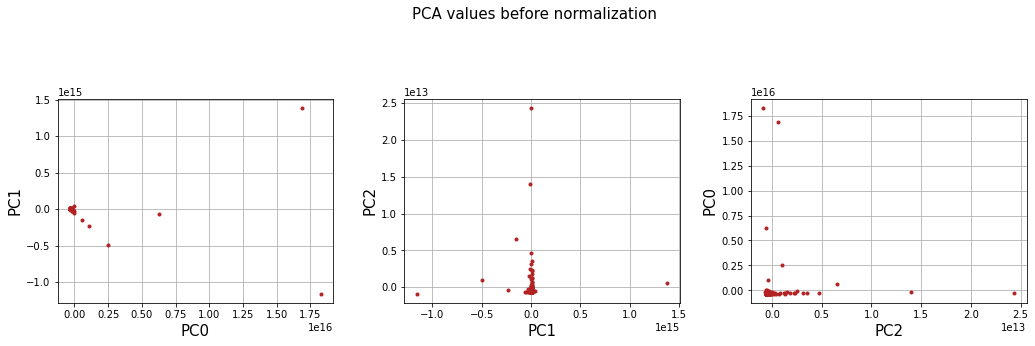

In [114]:
#creating a matrix from the dataset

array_of_dataframe_values = df_dropped_countries_fifth.to_numpy()


#performing PCA to get the three principal components

pca = PCA(n_components = 3, random_state=42)
pca_transformed = pca.fit_transform(array_of_dataframe_values)


pc0 = []
pc1 = []
pc2 = []

for i in range(0,len(pca_transformed)):
    pc0.append(pca_transformed[i][0])
    pc1.append(pca_transformed[i][1])
    pc2.append(pca_transformed[i][2])
    

#let's plot the PCA values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('PCA values before normalization', fontsize = 15)
fig.tight_layout(pad=4.0)

ax1.plot(pc0, pc1, 'o', color = 'firebrick', markersize = 3)
ax1.set_ylabel('PC1', fontsize = 15)
ax1.set_xlabel('PC0', fontsize = 15)
ax1.grid()

ax2.plot(pc1, pc2, 'o', color = 'firebrick', markersize = 3)
ax2.set_ylabel('PC2', fontsize = 15)
ax2.set_xlabel('PC1', fontsize = 15)
ax2.grid()

ax3.plot(pc2, pc0, 'o', color = 'firebrick', markersize = 3)
ax3.set_ylabel('PC0', fontsize = 15)
ax3.set_xlabel('PC2', fontsize = 15)
ax3.grid()


plt.show()

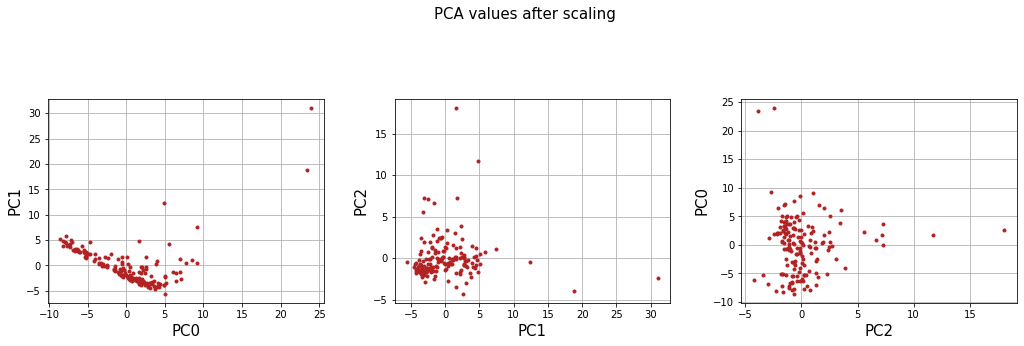

In [115]:
#as it's seen, the embedding is really dominated by a single direction
#we need to normalize the data to achive better results
#we can use different kinds of scalers do do the normalisation.
#we can start with using StandardScaler()
#the results are the following:

scaler = preprocessing.StandardScaler()

norm_array = scaler.fit_transform(array_of_dataframe_values)
pca_transformed_norm = pca.fit_transform(norm_array)

pc0_norm = []
pc1_norm = []
pc2_norm = []

for i in range(0,len(pca_transformed_norm)):
    pc0_norm.append(pca_transformed_norm[i][0])
    pc1_norm.append(pca_transformed_norm[i][1])
    pc2_norm.append(pca_transformed_norm[i][2])
    

#let's plot the scaled PCA values
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('PCA values after scaling', fontsize = 15)
fig.tight_layout(pad=4.0)

ax1.plot(pc0_norm, pc1_norm, 'o', color = 'firebrick', markersize = 3)
ax1.set_ylabel('PC1', fontsize = 15)
ax1.set_xlabel('PC0', fontsize = 15)
ax1.grid()

ax2.plot(pc1_norm, pc2_norm, 'o', color = 'firebrick', markersize = 3)
ax2.set_ylabel('PC2', fontsize = 15)
ax2.set_xlabel('PC1', fontsize = 15)
ax2.grid()

ax3.plot(pc2_norm, pc0_norm, 'o', color = 'firebrick', markersize = 3)
ax3.set_ylabel('PC0', fontsize = 15)
ax3.set_xlabel('PC2', fontsize = 15)
ax3.grid()


plt.show()

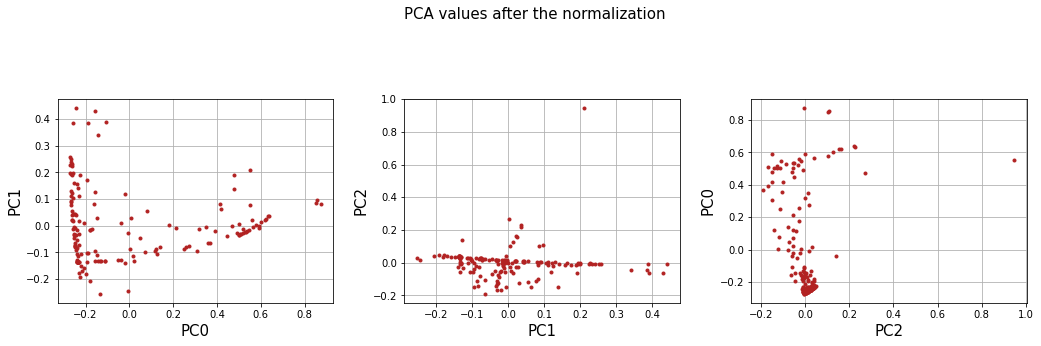

In [116]:
#we can calso try using preprocessing.scale()
#as it's seen, we got completely different results now
#this is due to the different scaling technique

norm_array2 = preprocessing.normalize(array_of_dataframe_values)
pca_transformed_norm2 = pca.fit_transform(norm_array2)

pc0_norm2 = []
pc1_norm2 = []
pc2_norm2 = []

for i in range(0,len(pca_transformed_norm2)):
    pc0_norm2.append(pca_transformed_norm2[i][0])
    pc1_norm2.append(pca_transformed_norm2[i][1])
    pc2_norm2.append(pca_transformed_norm2[i][2])


#let's plot the normalized PCA values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('PCA values after the normalization', fontsize = 15)
fig.tight_layout(pad=4.0)

ax1.plot(pc0_norm2, pc1_norm2, 'o', color = 'firebrick', markersize = 3)
ax1.set_ylabel('PC1', fontsize = 15)
ax1.set_xlabel('PC0', fontsize = 15)
ax1.grid()

ax2.plot(pc1_norm2, pc2_norm2, 'o', color = 'firebrick', markersize = 3)
ax2.set_ylabel('PC2', fontsize = 15)
ax2.set_xlabel('PC1', fontsize = 15)
ax2.grid()

ax3.plot(pc2_norm2, pc0_norm2, 'o', color = 'firebrick', markersize = 3)
ax3.set_ylabel('PC0', fontsize = 15)
ax3.set_xlabel('PC2', fontsize = 15)
ax3.grid()


plt.show()

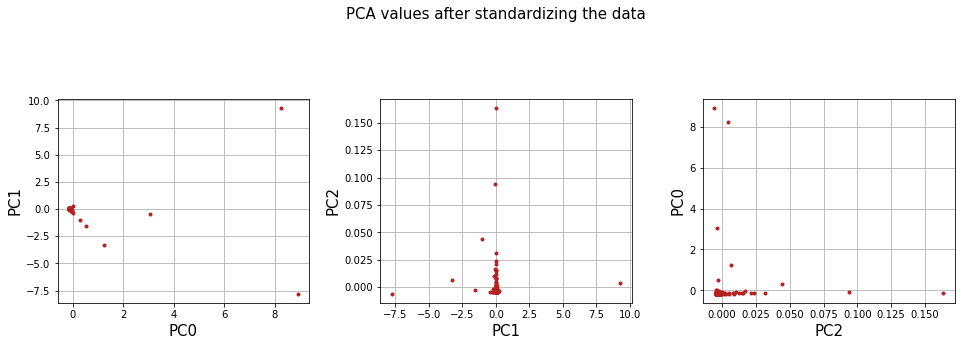

In [120]:
#these were not very effective ways to scale/normalize the data, so we need a different approach
#we need to achieve that each feature has zero mean and unit variance after normalization
#this can be done with the following method
#we subtract the mean from each element and devide by the standard deviation

p0_std = np.std(pc0)
p0_mean = np.mean(pc0)
p1_std = np.std(pc1)
p1_mean = np.mean(pc1)
p2_std = np.std(pc1)
p2_mean = np.mean(pc1)

pc0_standardized = []
pc1_standardized = []
pc2_standardized = []

for i in range(0,len(pca_transformed)):
    pc0_standardized.append((pc0[i]-p0_mean)/p0_std)
    pc1_standardized.append((pc1[i]-p1_mean)/p1_std)
    pc2_standardized.append((pc2[i]-p2_mean)/p2_std)
    
    
#let's plot the PCA values

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,5))
fig.suptitle('PCA values after standardizing the data', fontsize = 15)
fig.tight_layout(pad=4.0)

ax1.plot(pc0_standardized, pc1_standardized, 'o', color = 'firebrick', markersize = 3)
ax1.set_ylabel('PC1', fontsize = 15)
ax1.set_xlabel('PC0', fontsize = 15)
ax1.grid()

ax2.plot(pc1_standardized, pc2_standardized, 'o', color = 'firebrick', markersize = 3)
ax2.set_ylabel('PC2', fontsize = 15)
ax2.set_xlabel('PC1', fontsize = 15)
ax2.grid()

ax3.plot(pc2_standardized, pc0_standardized, 'o', color = 'firebrick', markersize = 3)
ax3.set_ylabel('PC0', fontsize = 15)
ax3.set_xlabel('PC2', fontsize = 15)
ax3.grid()

plt.show()

In [118]:
#as it's seen, this standardizing method follows the original data's shape
#we have seccuessfully scaled o ur data!

### 4. T-SNE
 - Perform T-SNE on the scaled data with 2 components
 - Plot the embeddings results. Add a text label for each point to make it possible to interpret the results. It will not be possible to read all, but try to make it useful, see the attached image as an example!
 - Highlight Hungary and Norway! Which countries are the closest one to Hungary and Norway? 

In [162]:
#getting the columns of the dataset and scaling them by the same method as before:

matrix_of_scaled_values = []

for j in values_for_dict:
    list_of_column_values = list(map(float,np.array(df_dropped_countries_fifth[j])))
    
    mean_of_column = np.mean(list_of_column_values)
    stdev_of_column = np.std(list_of_column_values)
    array_of_column_values_scaled = (np.array(list_of_column_values)-mean_of_column)/stdev_of_column
    
    matrix_of_scaled_values.append(list(array_of_column_values_scaled))


#since I used a different method in getting the data now, we have to transpose the resulted matrix
    
matrix_of_scaled_values = list(map(list, zip(*matrix_of_scaled_values)))

In [213]:
#performin T-SNE on the already scaled dataset

tsne = TSNE(n_components = 2, random_state = 42)
embedded = tsne.fit_transform(matrix_of_scaled_values)


#checking if the transpose was successful:

print(len(embedded))

#let's transpose the result again, for the easier plotting:

embedded = list(map(list, zip(*embedded)))

162


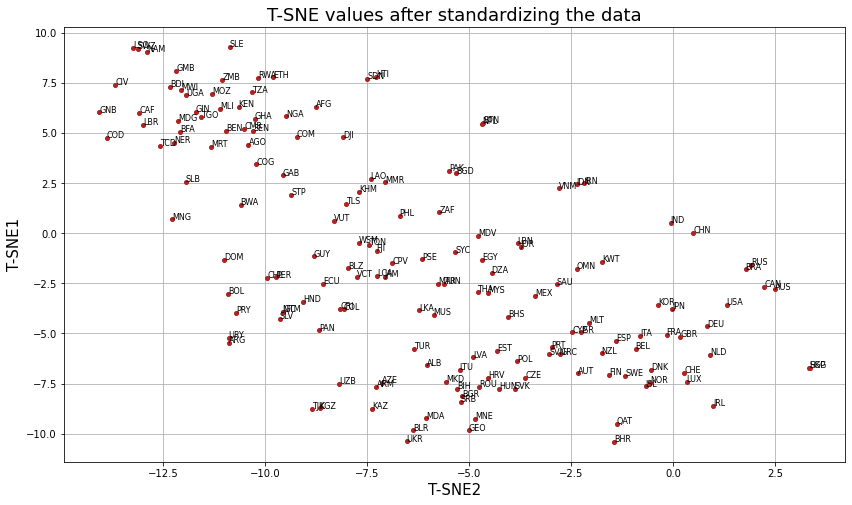

In [212]:
#let's plot the result of the T-SNE

plt.figure(figsize=(14,8))
plt.title('T-SNE values after standardizing the data', fontsize = 18)

for i in range(0,len(embedded[0])):
    plt.plot(embedded[0][i], embedded[1][i], 'o', color = 'firebrick', markersize = 4)
    
for i, txt in enumerate(country_code_list_filtered):
    plt.annotate(txt, (embedded[0][i], embedded[1][i]), fontsize = 8)    

plt.ylabel('T-SNE1', fontsize = 15)
plt.xlabel('T-SNE2', fontsize = 15)
plt.grid()    
plt.show()

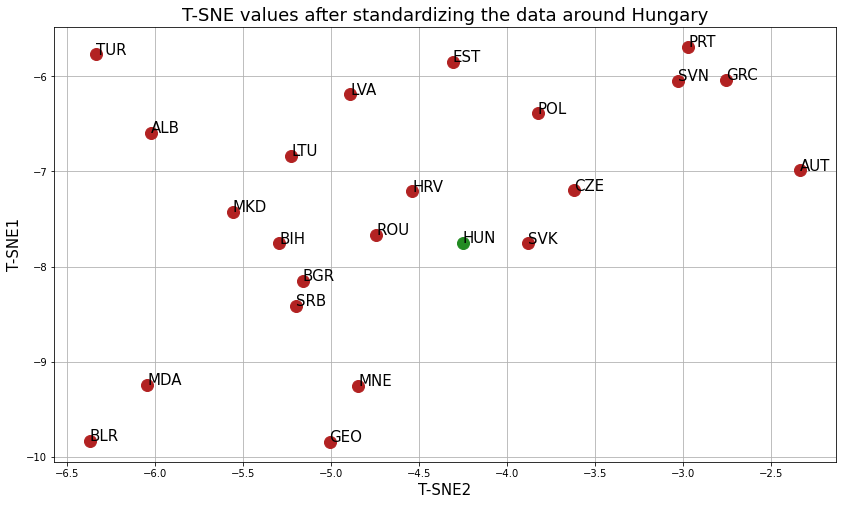

In [241]:
#as it's seen, we don't really know where Norway and Hungary are
#let's figure out the values of these two countries and only plot a small range around them!
#we already know the indices of these elements: HUN - 66, NOR - 112

plt.figure(figsize=(14,8))
plt.title('T-SNE values after standardizing the data around Hungary', fontsize = 18)

#plt.ylim(embedded[1][hun_index] + 2.5, embedded[1][hun_index] - 2.5)
#plt.xlim(embedded[0][hun_index] + 2.5, embedded[0][hun_index] - 2.5)

for i in range(0,len(embedded[0])):    
    if abs(embedded[0][hun_index]-embedded[0][i]) < 2.5 and abs(embedded[1][hun_index]-embedded[1][i]) < 2.5:
        if i == hun_index:
            plt.plot(embedded[0][i], embedded[1][i], 'o', color = 'forestgreen', markersize = 12)
            plt.annotate(country_code_list_filtered[i], (embedded[0][i], embedded[1][i]), fontsize = 15) 
        else:
            plt.plot(embedded[0][i], embedded[1][i], 'o', color = 'firebrick', markersize = 12)
            plt.annotate(country_code_list_filtered[i], (embedded[0][i], embedded[1][i]), fontsize = 15) 

plt.ylabel('T-SNE1', fontsize = 15)
plt.xlabel('T-SNE2', fontsize = 15)

plt.grid()    
plt.show()

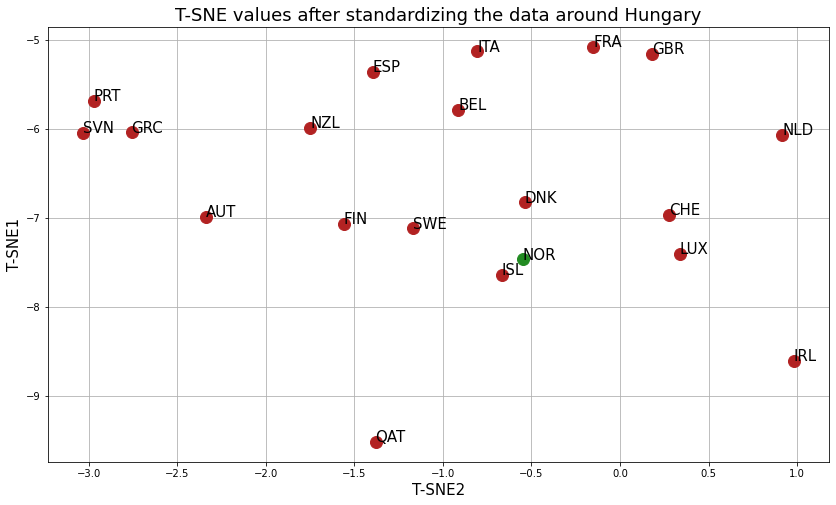

In [243]:
#let's plot the close countries to Norway!

plt.figure(figsize=(14,8))
plt.title('T-SNE values after standardizing the data around Hungary', fontsize = 18)

for i in range(0,len(embedded[0])):    
    if abs(embedded[0][nor_index]-embedded[0][i]) < 2.5 and abs(embedded[1][nor_index]-embedded[1][i]) < 2.5:
        if i == nor_index:
            plt.plot(embedded[0][i], embedded[1][i], 'o', color = 'forestgreen', markersize = 12)
            plt.annotate(country_code_list_filtered[i], (embedded[0][i], embedded[1][i]), fontsize = 15) 
        else:
            plt.plot(embedded[0][i], embedded[1][i], 'o', color = 'firebrick', markersize = 12)
            plt.annotate(country_code_list_filtered[i], (embedded[0][i], embedded[1][i]), fontsize = 15) 

plt.ylabel('T-SNE1', fontsize = 15)
plt.xlabel('T-SNE2', fontsize = 15)

plt.grid()    
plt.show()

In [ ]:
#As it's seen, there are some countries which are similar to both Norway and Hungary
#by the case of Hungary, when I calculated the most similar country in the values of the features, I got Czech republic 
#from the T-SNE graph, we can see that they actually are very close to each other
#in the case of Norway, Austria is the most similar one according to all the data 
#In this T-SNE map, they are quite far away from each other
#this might be due to the fact that there were some data, which weighted much more in the overall similarities than the only two, which we considered when doing the T-SNE calculation

### 5. Hierarchical clustering

 - Perform hierarchical clustering on the filtered and scaled data (hint: use seaborn)
 - Try to plot in a way that all country's name is visible
 - Write down your impressions that you got from this plot!

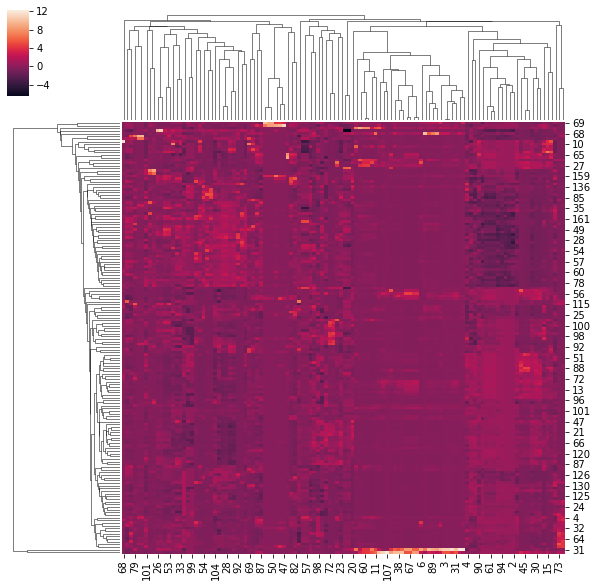

In [288]:
#let's use seaborn to plot the hierarchical clustering graph!
#for this, first I'll be using the array, which has already been scaled:

g = sns.clustermap(matrix_of_scaled_values)

In [289]:
#as it's seen, we do not see the country names on either of the axes
#I decided to scale the dataframe in pandas format and then use that data in plotting
#as it's seen later, the labels are correct when using the dataframe

df_dropped_countries_sixth = df_dropped_countries_fifth.astype(float)

for j in values_for_dict:
    df_dropped_countries_sixth[j] = (df_dropped_countries_sixth[j] - np.mean(df_dropped_countries_sixth[j]))/np.std(df_dropped_countries_sixth[j])

df_dropped_countries_sixth.head()

,1,2,3,31,34,37,40,58,59,89,...,1219,1231,1232,1279,1341,1344,1380,1408,1409,1410
Afghanistan,-0.363416,-0.342214,0.087700,-0.210947,-0.978837,-0.309959,-0.290194,0.823822,0.132310,-0.273039,...,-0.499006,-0.155961,-0.478024,-0.059842,-0.184320,-0.681325,-1.223354,-0.202230,-1.462610,1.120160
Albania,0.661653,0.698024,0.564177,-0.215759,-0.654724,-0.298974,-0.285255,0.107365,-0.390434,0.483898,...,0.608377,-0.155213,-0.437787,-0.360480,-0.183192,-0.493984,0.789362,-0.295297,-0.030689,-0.401895
Algeria,0.659184,0.691111,0.564177,-0.054031,0.166858,1.590878,-0.287647,-1.091529,0.182775,-0.901300,...,0.608377,-0.155487,-0.477006,0.772973,-0.169668,1.533920,0.349081,0.063007,0.557948,0.492433
Angola,-1.424452,-2.126268,-1.722912,-0.183127,-0.382021,0.751390,-0.290436,0.324973,0.435121,-0.844121,...,-0.499006,-0.155031,-0.474385,0.226215,-0.108241,0.758709,-1.034662,-0.078396,0.233131,1.502944
Argentina,0.655435,0.643313,0.563166,-0.001725,0.652441,0.238401,0.087948,0.648034,1.708836,-0.098772,...,-0.499006,-0.124092,-0.404445,0.965010,-0.058668,-0.559080,0.789362,0.216118,1.464336,-0.567838


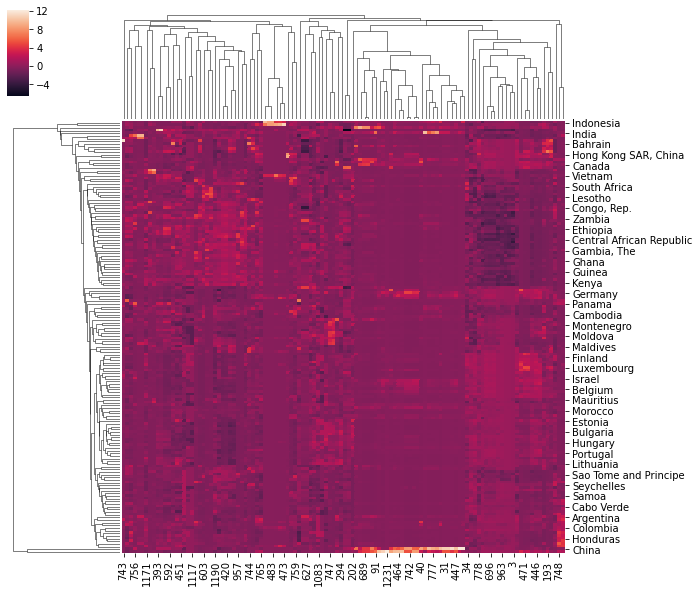

In [290]:
#plotting the clustering

g = sns.clustermap(df_dropped_countries_sixth)

In [ ]:
#this method basically grouped the similar object into clusters
#as it's seen, at first there are smaller clusters
#and as we go further and further, the cluster will contain more and more values in both axes
#first step is the identification of two clusters and then merging them

#suprisingly, the countries are very similar to each other at first and then there are two outliners, which collect all the data
#compared to this, the other group of data, the similar elements are much much closer to each other